 # RNN: Ozon Seviyesi Tahmini için LSTM Yöntemi
Veri Seti: https://archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection

*Bu uygulamanın amacı bir zaman serisi sınıflandırma problemini çözmektir. Hedef değişken, Houston, Texas'ta belirli bir gün için ozon seviyesinin yüksek olup olmadığıdır.* Belirleyici değişkenleri aşağıdaki gibidir:

- `WSR` değişkenleri: Rüzgar hızı (Wind Speep) (Günün her saati için bir veri bulunmaktadır).
- `WSR_PK`: O gün için en yüksek rüzgar hızı.
- `WSR_AV`: O gün için ortalam rüzgar hızı.
- `T` değişkenleri: Sıcaklık (Temperature) (Günün her saati için bir veri bulunmaktadır).
- `T_PK`: O gün için tepe sıcaklık.
- `T_AV`: O gün için ortalama sıcaklık.
- Rüzgar yönüne göre ozon arka plan seviyesi, Öncü emisyonlarla ilgili faktör, Gün için Toplam Güneş Radyasyonu. (U, HT, TH, V...).
- `SLP`: Deniz seviyesindeki hava basıncı.
- `SLP_`: Gün içindeki SLP seviyesi farkı .
- `KI`: K-Index.
- `TT`: T (Toplamlar).


Kütüphaneler:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve, f1_score,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from numpy.random import seed

# 1. Yardımcı Fonksiyonlar



### 1.1 Çok zamanlı algoritmalar için Gecikme işlemi

Çok değişkenli zaman serileriyle çalışırken, geleceği tahmin ederken "geçmişi" kullanabilmek için veriler dönüştürülmelidir. Aşağıdaki işlev, bir veri çerçevesinin değişkenlerini alır ve şu değişkenlerin gecikmelerini yaratır: t-1,t-2 ... t-x, böylece ML modellerine ve hatta bir Çok Katmanlı Perceptron NN'ye uyacak şekilde hemen kullanılabilir.
Random Forest ile özellik seçimi için kullanılacaktır.

In [2]:
def supervised_lag(data, max_lag):
    df = data.copy() # orjinal dataframe i bozmamak için
    c = pd.DataFrame() # boş dataframe
    for name in df.columns:
        for i in range(max_lag,0,-1): # tersten saymaya başla
            c[name+str(-i)]=df[name].shift(i) # Lag
        c[name] = df[name]
    
    c = c.dropna().reset_index(drop=True)
    # Yeniden boyutlandırma : gözlem sayısı, değişkenler, gecikmeler (t(şuanki zaman) yi de barındırdığı içim +1))
    
    return c

### 1.2 Eğitim/Test 
Veriyi eğitim ve test verisi olarak bölmek için kullanılacak fonksiyon.

In [3]:
def ts_train_test(data, predictors, target, time):
    """
    predictors: belirleyici değişkenlerin isimlerinin bulunduğu liste
    targer: Hedef değişken ismi (string)
    time: Testin uzunluğu (int)
    """
    train_X = data[predictors][:-time]
    train_y = data[target][:-time]
    test_X = data[predictors][-time:]
    test_y = data[target][-time:]
    
    return train_X, train_y, test_X, test_y

### 1.3 Sinir Ağları için Gecikme işlemi  (CNN, LSTM...)

Verilerin üç boyutlu bir yapıda olması gerektiğinden, RNN veya CNN'ye uyması için bir dönüşüm daha gereklidir.
"supervised_lag" işlevine benzer, ancak aynı zamanda 2d veri çerçevesini 3d tensöre yeniden dönüştürür. Zaman serisi için boyutlar:
- Gözlem sayısı.
- Sıralamayı yapmak için Zaman Adımları.
- Değişken sayısı.

In [4]:
def ts_lag(data, max_lag):
    df = data.copy() # orjinal dataframe i bozmamak için
    c = pd.DataFrame() # boş dataframe
    for name in df.columns:
        for i in range(max_lag,0,-1): # tersten saymaya başla
            c[name+str(-i)]=df[name].shift(i) # Gecikme
        c[name] = df[name]
    
    c = c.dropna().reset_index(drop=True)
    # Yeniden boyutlandırma : gözlem sayısı, değişkenler, gecikmeler (t(şuanki zaman) yi de barındırdığı içim +1))
    c = c.values.reshape(len(c),len(data.columns),max_lag+1) 
    
    # üstteki kod verinin yatay olarak yeniden şekillendirilmesini için, her sütunda veri olmasına ihtiyacımız var ---> Transpose
    l = [] 
    for i in range(0,len(c)):
        l.append(c[i].transpose())
    
    return np.array(l)

### 1.4 Test için Gecikme Değişkenleri

Gecikme değişkenleri oluşturmayla ilgili bir sorun, gecikme arttıkça gözlemlerin kaybolmasıdır. eğitimde ve testte aynı dönüşümler yapılmalı, ancak satırlar eğitim içinde kaybolabilirken testte kaybolmamalıdır. Mesele şu ki, testte bir değişkeni geciktirdiğinizde, önceki değer hala eğitimdedir. **Daha basit bir alternatif, önce tüm veri kümesini geciktirmek ve ardından bölmektir.**

In [5]:
def ts_lag_test(train_original, test, max_lag):
    train = train_original.copy() # Fonksisyon içindeki hataları önlemek için
    test = test.copy()
    c = pd.DataFrame() # Yeni gecikme değişkenlerini sırayla eklemek için boş veri kümesi.
    for name in test.columns: # Değişkenlerin adı.
        for i in range(max_lag,0,-1): # Sıralanmış bir t-2,t-1,t dizisi istiyoruz. Bu yüzden de önce  max gecikmeyi hesaplıyoruz ve sonra azalan gidiyoruz. 0 dahil değildir.
            c[name+str(-i)]=test[name].shift(i)
            c[name+str(-i)][0:i] = train[name][len(train)-i:len(train)] # NA değerini tüm eğtimin son gözlemiyle değiştirin.
        c[name] = test[name]
        
        
    c = c.dropna().reset_index(drop=True)
    # Yeniden boyutlandırma : gözlem sayısı, değişkenler, gecikmeler (t(şuanki zaman) yi de barındırdığı içim +1))
    c = c.values.reshape(len(c),len(train_original.columns),max_lag+1) 
    
    # üstteki kod verinin yatay olarak yeniden şekillendirilmesini için, her sütunda veri olmasına ihtiyacımız var ---> Transpose
    l = [] 
    for i in range(0,len(c)):
        l.append(c[i].transpose())
    
    return np.array(l)

### 1.5 Model

Bu durumda RNN kullanımı gereklidir. LSTM'ler özellikle zaman serileri için iyi çalışır. Başlangıç olarak, tek bir gizli LSTM birimi katmanı ve tahminler yapmak için kullanılan bir Dense katmanı ile bir "vanilla" LSTM oluşturulacak. Sınıflandırma olduğu için, çıktı için aktivasyon fonksiyonu "Sigmoid" olmalıdır, çünkü her zaman 0 ile 1 arasında sonuç alacaktır.

Bu ikili bir problemdir, bu nedenle kayıp İkili Çapraz Entropi olacaktır ve ampirik testlere dayanarak rmsprop adam'dan daha iyi çalıştı.
LSTM hakkında iyi bir düşünce, CNN'nin (tüm girdi vektörünü okuyan) aksine, LSTM'nin dizinin bir seferde bir adımını okuması ve tahmin yapmak için öğrenilmiş bir bağlam olarak kullanılabilecek bir dahili durum temsili oluşturmasıdır.

In [6]:
def make_LSTM(train_X,train_y,test_X,test_y,units,epochs,batch_size,seed):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(LSTM(units,
                      input_shape=(train_X.shape[1],train_X.shape[2])
                  ))
    model.add(Dense(1,activation="sigmoid")) # 0 - 1 arasında çıktı için sigmoid olmalıdır. 
    model.compile(loss="BinaryCrossentropy", optimizer="rmsprop", metrics=["AUC"])
    
    history=model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,
                         validation_data=(test_X,test_y), verbose=2, shuffle = False)
 
    return model, history

### 1.6 Evaluation 

Sinir Ağları, stokastik modellerdir, bu nedenle, başlangıçtaki ağırlıkların rastgeleliği nedeniyle sonuç değişebilir. Bu nedenle, birkaç Sinir ağını test etmeniz ve sonuçların sabit olup olmadığını kontrol etmeniz önerilir.
Ayrıca modeli grafiksel olarak değerlendirmek için oldukça basit 3 fonksiyon oluşturulmuştur.

In [7]:
def evaluate_nn(train_X_R, test_X_R, test_y, seed, units=16,epochs=50,batch_size=64):
    loss_list,auc_list=list(),list()
    i=seed
    model, _=make_LSTM(train_X_R, train_y, test_X_R, test_y, units, epochs, batch_size, seed=i)
    loss, auc = model.evaluate(test_X_R,test_y,verbose=1)
    loss_list.append(loss)
    auc_list.append(auc)
    return np.mean(loss_list),np.mean(auc_list)

def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title("LOSS")
    plt.show()
    
def plot_auc(history):
    plt.plot(history.history['auc'], label='train')
    plt.plot(history.history['val_auc'], label='test')
    plt.legend()
    plt.title("AUC")
    plt.show()
    
def plot_roc(y_real, y_pred):
    false_positive_rate, recall, thresholds = roc_curve(y_real, y_pred)
    roc_auc = auc(false_positive_rate, recall)
    print(f'- AUC: {roc_auc}')
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC AUC = %0.2f' % roc_auc)

### 1.7 Hiper Parametelerin Ayarlanması

Sinir ağlarının ayarlanması gereken oldukça hiperparametreleri vardır. nöron sayısı, batch mikttarı, epoch sayısı, optimize edici, Dropout oranı... Bu fonksiyon, olası tüm kombinasyonlardan geçer ve modeli farklı seedler üzerinde değerlendirir.

In [8]:
def tune_nn(units, epochs, batch_size,seed_size):
    
    """
    # LIST format []
    """
    dic={
        "units":[],
        "epochs":[],
        "batch_size":[],
        "AUC":[],
        "Seed":[]
    }
    for u in range(len(units)):
        for i in range(len(epochs)):
            for j in range(len(batch_size)):
                for t in range(len(seed_size)):
                    print(units[u],epochs[i],batch_size[j],seed_size[t])

                    _,avg_auc=evaluate_nn(train_X_R, test_X_R, test_y, seed_size[t],
                                          units=units[u],epochs=epochs[i],batch_size=batch_size[j])
                    dic["units"].append(units[u])
                    dic["epochs"].append(epochs[i])
                    dic["batch_size"].append(batch_size[j])
                    dic["AUC"].append(avg_auc)
                    dic["Seed"].append(seed_size[t])
                    dicc=pd.DataFrame(dic)
                    dicc.sort_values(by=['AUC'])
    return dicc

ekstra EDA için fonksiyonlar;

In [9]:
def filter_startswith(columns_vector, pattern):
    mask = []
    for i in columns_vector.values: mask.append(i.startswith(pattern))
    return columns_vector.values[mask]

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

# 2. Veri içeri aktarılır:
- NaN değerleri "?" olarak kaydedildi
- "Date", zaman değişkeniydi, bu nedenle datetime64'e dönüştürüldü ve dizin olarak ayarlandı.

In [10]:
ozone = pd.read_csv(
    #"https://raw.githubusercontent.com/r4msi/LSTM_Ozone/master/ozone.csv",
    "./ozone.csv",
    parse_dates=["Date"],
    index_col="Date",
    dtype=float,
    na_values="?"
)

In [11]:
ozone.shape

(2534, 73)

In [12]:
#ozone.to_csv('ozone.csv')

# 3. Keşifsel Veri Analizi EDA

EDA işlemi Sweetviz kütüphanesi ile otomatikleştirilebilir. Ancak bir "manuel" EDA da yapılacaktır.

In [13]:
#ozone_report = sv.analyze(ozone, target_feat="target")
# ozone_report.show_html('ozone.html')

### 3.1 Genel istatistikler

Veri seti, "Tarih" dikkate alınarak 2534 gözlem ve 74 değişkenden oluşmaktadır.

In [14]:
print(f" -Observations: {ozone.shape[0]}\n -Variables: {ozone.shape[1]}")
ozone.head()

 -Observations: 2534
 -Variables: 73


,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,target
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.15,10.67,-1.56,5795.0,-12.10,17.9,10330.0,-55.0,0.00,0.0
1998-01-02,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.48,8.39,3.84,5805.0,14.05,29.0,10275.0,-55.0,0.00,0.0
1998-01-03,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.60,6.94,9.80,5790.0,17.90,41.3,10235.0,-40.0,0.00,0.0
1998-01-04,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.49,8.73,10.54,5775.0,31.15,51.7,10195.0,-40.0,2.08,0.0
1998-01-05,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0.0


In [15]:
ozone.describe()

,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,target
count,2235.000000,2242.000000,2240.000000,2242.000000,2241.000000,2242.000000,2243.000000,2245.000000,2244.000000,2247.000000,...,2409.000000,2324.000000,2324.000000,2422.000000,2398.000000,2409.000000,2439.000000,2376.000000,2532.000000,2534.000000
mean,1.640179,1.586351,1.545580,1.526405,1.522624,1.542417,1.637896,2.047127,2.539037,2.847708,...,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.372026,0.063141
std,1.271999,1.266558,1.239822,1.205520,1.198999,1.172189,1.161568,1.160524,1.185366,1.221338,...,0.249082,9.531016,7.355254,79.180435,20.718131,11.229664,52.420524,35.828779,1.317959,0.243265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,...,0.010000,-14.920000,-25.990000,5480.000000,-56.700000,-10.100000,9975.000000,-135.000000,0.000000,0.000000
25%,0.600000,0.600000,0.600000,0.600000,0.600000,0.700000,0.800000,1.200000,1.700000,2.000000,...,0.090000,2.460000,-3.790000,5770.000000,-3.575000,32.300000,10130.000000,-20.000000,0.000000,0.000000
50%,1.300000,1.300000,1.200000,1.300000,1.300000,1.300000,1.400000,1.900000,2.500000,2.800000,...,0.230000,9.250000,0.360000,5835.000000,14.925000,41.100000,10160.000000,0.000000,0.000000,0.000000
75%,2.400000,2.300000,2.200000,2.200000,2.200000,2.100000,2.200000,2.800000,3.300000,3.700000,...,0.470000,16.712500,4.867500,5880.000000,28.350000,45.100000,10195.000000,15.000000,0.050000,0.000000
max,7.500000,7.700000,7.100000,7.300000,7.200000,7.400000,7.400000,7.500000,9.200000,8.500000,...,1.000000,42.360000,30.420000,5965.000000,42.050000,59.150000,10350.000000,140.000000,20.650000,1.000000


Veriler, neredeyse 7 yıllık yer ozon konsantrasyonunu tanımlıyor.

In [16]:
print(f"{np.min(ozone.index)}\n{np.max(ozone.index)}")

1998-01-01 00:00:00
2004-12-31 00:00:00


### 3.2 NaN veriler

Tarih ve hedef dışındaki her sütunun NaN içerdiği görülüyor. 300 eksik değer, bu değişkenler için yaklaşık %12'yi temsil eder.

In [17]:
np.array(ozone.isnull().sum())

array([299, 292, 294, 292, 293, 292, 291, 289, 290, 287, 288, 292, 287,
       288, 288, 286, 284, 283, 286, 292, 294, 293, 300, 297, 273, 273,
       190, 185, 187, 184, 184, 183, 183, 183, 185, 185, 188, 192, 189,
       191, 192, 187, 184, 182, 184, 188, 189, 185, 192, 189, 175, 175,
        99, 105, 180, 180,  95, 107, 115, 157, 157, 100, 115, 125, 210,
       210, 112, 136, 125,  95, 158,   2,   0], dtype=int64)

### 3.3 Target Distribution

Tepki değişkeninde çok güçlü bir dengesizlik gözlemlenir. Doğruluk iyi bir model performans metriği olmayacaktır, AUC veya F-puanı önerilir. Ozon günleri %6.7'yi temsil eder.

C:\Users\boral\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


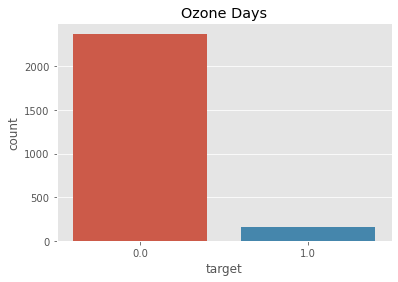

In [18]:
fig=sns.countplot(ozone.target)
fig=plt.title("Ozone Days")

In [19]:
pd.crosstab(ozone.target, "count")

col_0,count
target,
0.0,2374
1.0,160


Yıla göre grafik gösterimi:

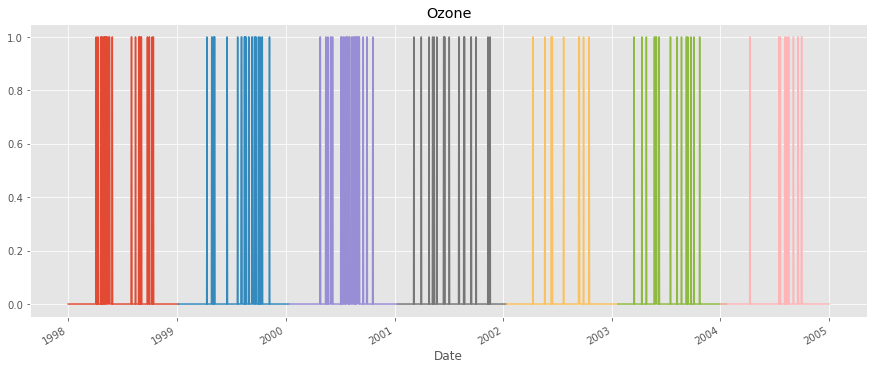

In [20]:
fig=plt.figure(figsize=(15,6))
fig=plt.subplot()
fig = ozone.target[:365].plot()
fig = ozone.target[365:730].plot()
fig = ozone.target[730:1095].plot()
fig = ozone.target[1095:1460].plot()
fig = ozone.target[1460:1825].plot()
fig = ozone.target[1825:2190].plot()
fig=ozone.target[-365:].plot()
fig=plt.title("Ozone")

### 3.4 Belirleyiciler

Veri seti Rüzgar Hızı ve Sıcaklık nedeniyle çok fazla değişken içerir: *Günün her saati için kayıtlar vardır.* Bununla birlikte, ortalama değişkenleri de verilerde olduğundan tüm serileri çizmeye gerek yoktur. U50-U70, T85-T70 vb.

* WSR ve Sıcaklıktaki eksik değerler 2002'nin ikinci yarısına karşılık gelir. Kalan değişkenler için Random'da eksiktir (Yani enterpolasyon WSR ve Sıcaklık dışında iyi bir yöntem olacaktır).

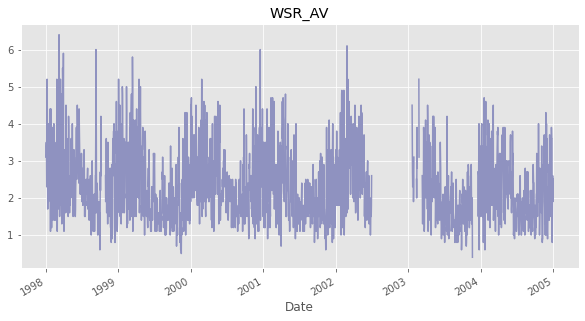

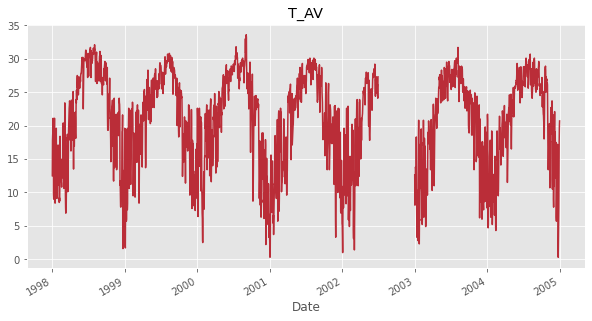

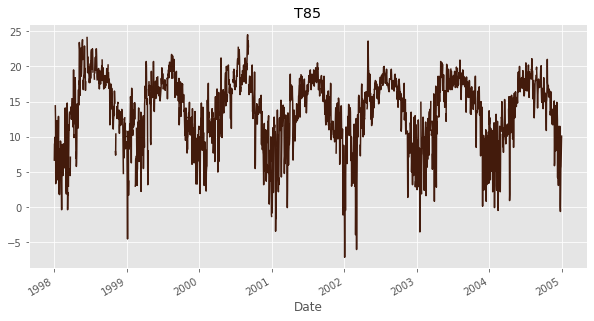

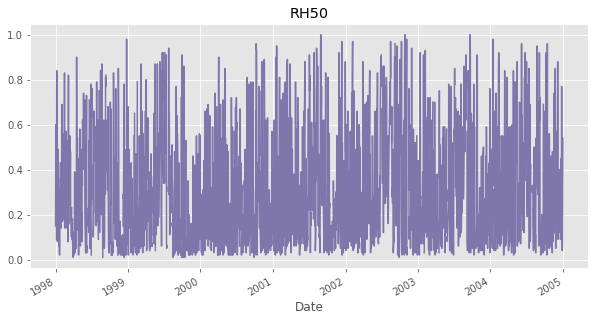

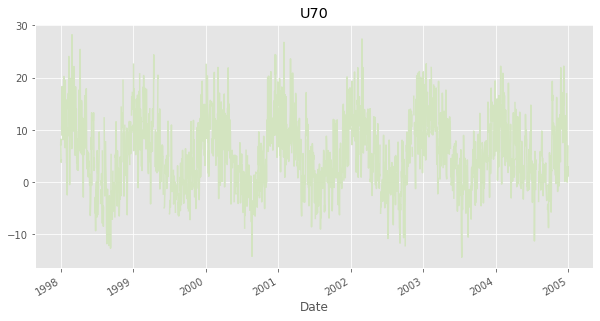

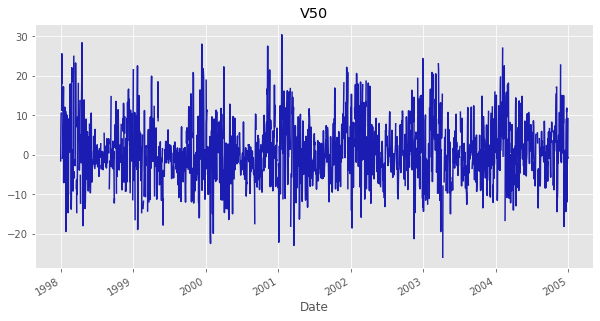

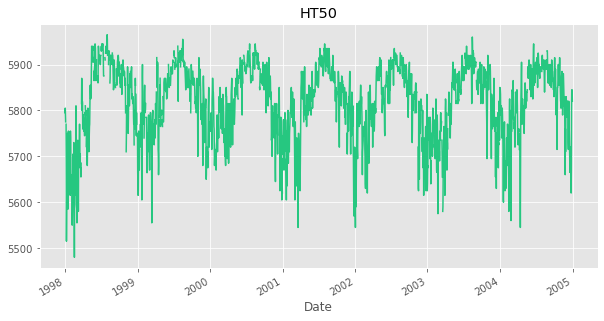

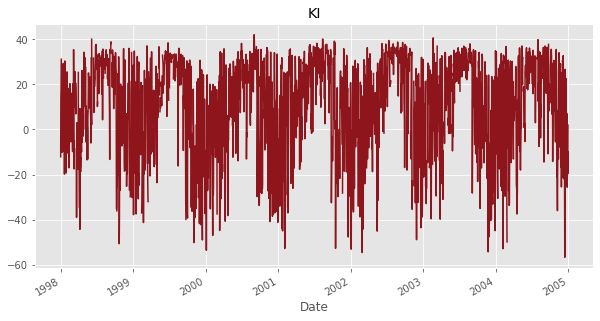

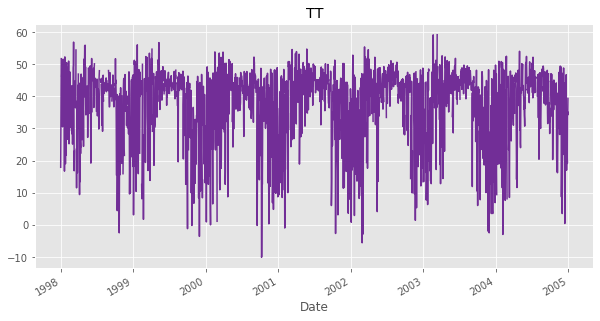

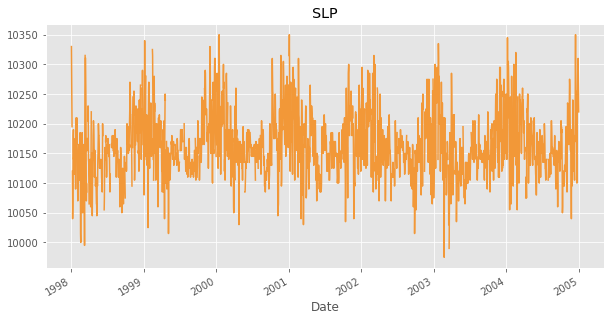

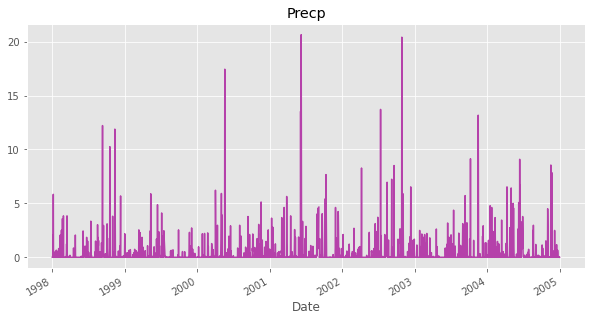

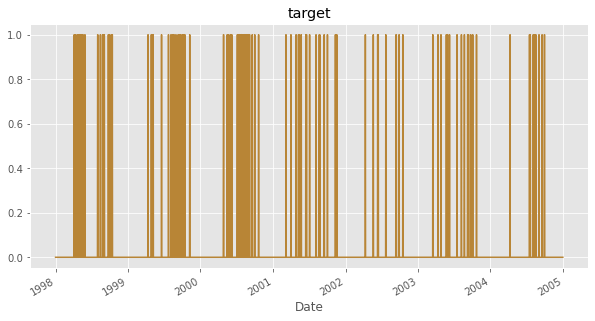

In [21]:
series = ["WSR_AV","T_AV","T85","RH50","U70","V50","HT50","KI","TT","SLP","Precp","target"] 
for i in series:
    fig=plt.figure(figsize=(10,5))
    fig=ozone[i].plot(c=np.random.rand(3,))
    fig=plt.title(i)
    fig=None

# 4. Imputation

ImputationZaman serileri için, enterpolasyon hızlı ve iyi bir değerleme yöntemidir:
- t-1 = 10 & t-3 = 20 için değerlere sahip olmak, t-2 eksikken, değiştirme t-1 ve t-3 arasındaki ortalama olacaktır; t-2=15.
Ancak sıcaklık ve WSR için net değil.
- Grafiklerde, WSR için çok doğru olmayacak gibi görünüyor.

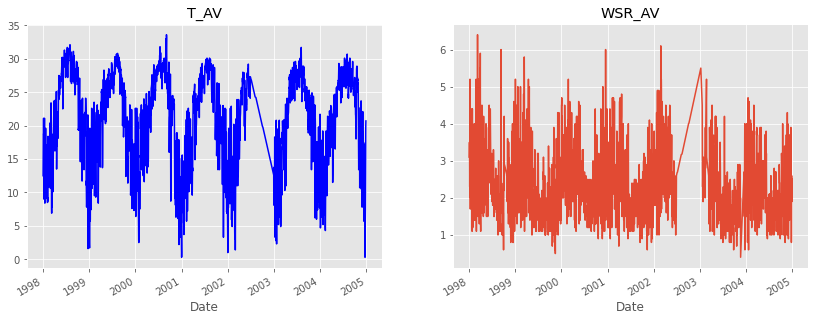

In [22]:
fig=plt.figure(figsize=(14,5))
fig=plt.subplot(1,2,1)
fig=ozone.T_AV.interpolate().plot(c="blue",title="T_AV")
fig=plt.subplot(1,2,2)
fig=ozone.WSR_AV.interpolate().plot(title="WSR_AV")

In [23]:
WSR_columns = filter_startswith(ozone.columns, "WSR")
len(WSR_columns)

26

In [24]:
ozone.iloc[:,26:]=ozone.drop(WSR_columns,axis=1).interpolate(method="linear",limit_direction='forward')
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
ozone[ozone.columns]=imputer.fit_transform(ozone)
ozone.isnull().sum()

WSR0      0
WSR1      0
WSR2      0
WSR3      0
WSR4      0
         ..
TT        0
SLP       0
SLP_      0
Precp     0
target    0
Length: 73, dtype: int64

WSR için ortalama tercih edildi.

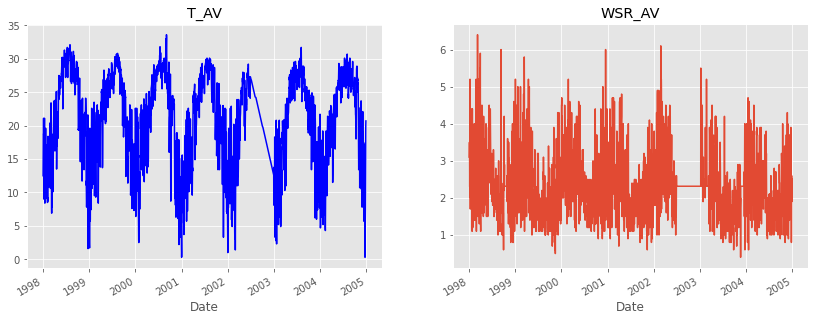

In [25]:
fig=plt.figure(figsize=(14,5))
fig=plt.subplot(1,2,1)
fig=ozone.T_AV.interpolate().plot(c="blue",title="T_AV")
fig=plt.subplot(1,2,2)
fig=ozone.WSR_AV.interpolate().plot(title="WSR_AV")

# 5 Doğrusal Korelasyon

Bu kadar çok değişkene sahip olmak bilgiyi gereksiz hale getirebilir ve bilgi işlem maliyetini artırabilir. Yani, sabah 00'daki sıcaklık, 1'inkine çok benzer olabilir, bu nedenle, ortalaması alınabilir ve bir değişken çıkarılabilir.

**Hedef değişken ikili olduğunda, pearson korelasyonu en iyi yöntem değildir, ancak yine de çalışır.**

- Günün merkezi saatlerindeki sıcaklıkların, hedef değişkenle daha yüksek bir korelasyonla nasıl ilişkili olduğuna dikkat edin.
- Bu yüzden T_pk de çok ilişkilidir. T_pk'ye sahip tüm bu değişkenleri kullanmanın anlamı yok.
- Belki T14,T15,T16 arasındaki ortalama.

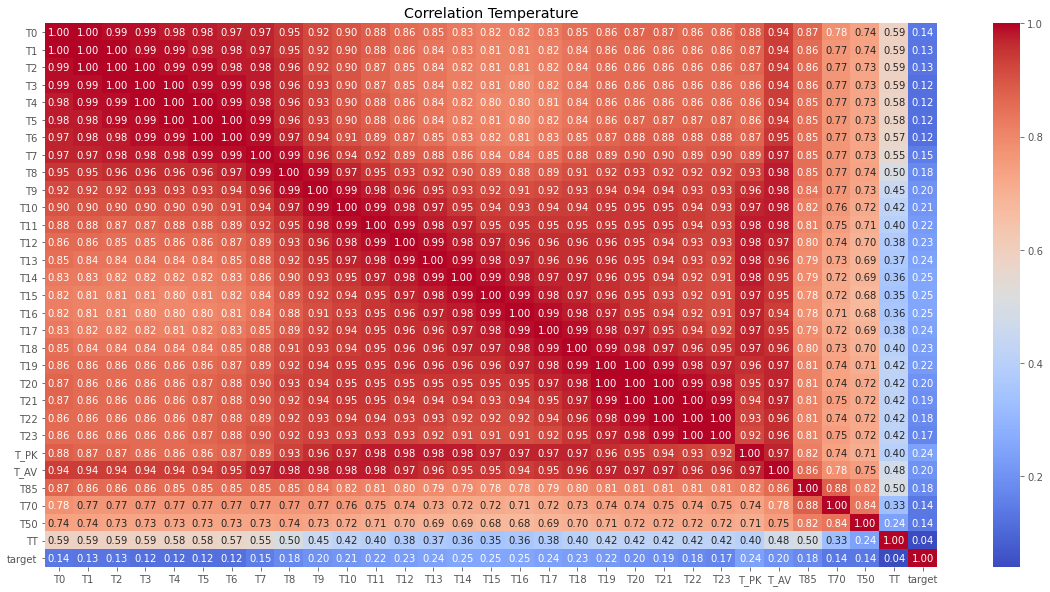

In [26]:
T_columns = filter_startswith(ozone.columns, "T")
T_columns = np.append(T_columns,"target")

corr = ozone[T_columns].corr()
fig = plt.figure(figsize=(20,10))
fig = sns.heatmap(round(corr,2), cmap="coolwarm",fmt='.2f',annot=True)
fig = plt.title("Correlation Temperature")

In [27]:
ozone["T14_16"]=(ozone.T14+ozone.T15+ozone.T16)/3
ozone[["target","T14_16", "T14","T15", "T16", "T_PK"]].corr("kendall")

,target,T14_16,T14,T15,T16,T_PK
target,1.000000,0.217010,0.216552,0.217591,0.214996,0.207097
T14_16,0.217010,1.000000,0.944631,0.975948,0.945214,0.909825
T14,0.216552,0.944631,1.000000,0.933546,0.891885,0.910878
T15,0.217591,0.975948,0.933546,1.000000,0.938125,0.900720
T16,0.214996,0.945214,0.891885,0.938125,1.000000,0.882755
T_PK,0.207097,0.909825,0.910878,0.900720,0.882755,1.000000


WSR ile daha fazla çeşitlilik var gibi görünüyor.

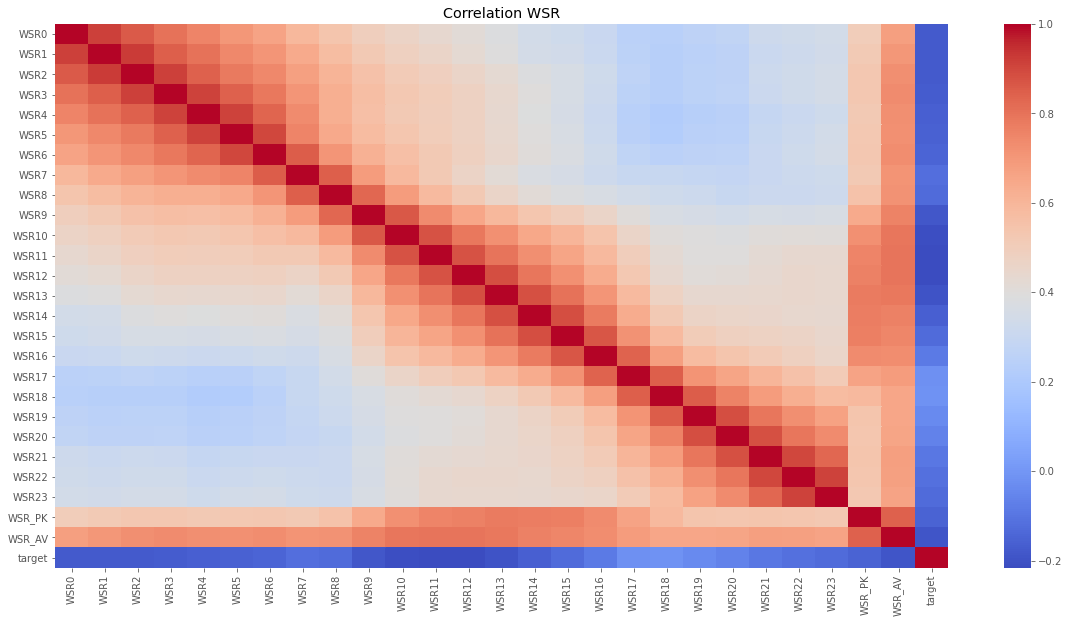

In [28]:
WSR_columns = filter_startswith(ozone.columns, "WSR")
WSR_columns = np.append(WSR_columns,"target")

corr = ozone[WSR_columns].corr()
fig = plt.figure(figsize=(20,10))
fig = sns.heatmap(round(corr,3), cmap="coolwarm",fmt='.2f')
fig = plt.title("Correlation WSR")

In [29]:
ozone["WSR10_13"]=(ozone.WSR10+ozone.WSR11+ozone.WSR12)/3

Kalan Değişkenler:

- T_PK ve T85, 0.88'lik bir pozitif korelasyona sahiptir.
- KI & TT 0,86.
- Hedef değişkenle güçlü bir doğrusal ilişki yoktur.

In [ ]:
features = ["WSR_PK","T_PK","T85","T70","RH70","RH50","U70","U50","V50","V70","HT70","HT50","KI","TT","SLP","SLP_","Precp","target"]
corr = ozone[features].corr()
fig = plt.figure(figsize=(11,7))
fig = sns.heatmap(round(corr,2), cmap="coolwarm",fmt='.2f', annot=True)
fig = plt.title("Correlation Importance Variables")

# 6. Boyutsal Küçültme


In [ ]:
scaler=MinMaxScaler()
x=scaler.fit_transform(ozone.drop("target",axis=1))
tsne_fitting = TSNE(n_components=2, perplexity=25, n_iter=250, learning_rate=100, metric="braycurtis")
X_embedded = tsne_fitting.fit_transform(x)
plot_data = pd.DataFrame([])
plot_data['tsne-one'] = X_embedded[:,0]
plot_data['tsne-two'] = X_embedded[:,1]
plot_data['y'] = ozone.target.values
plt.figure(figsize=(16,10))
plt.title('t-SNE vs Target')
fig=sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="y",
    data=plot_data,
)

# 7 Öznitelik Seçimi

Değişkenleri seçmenin mantıklı bir yolu, daha çok değişkenden daha az değişkene kadar tüm olası model kombinasyonlarını oluşturmak ve en iyisini elde etmektir. Buna yaklaşmanın bir yolu, ağaçları oluşturmak için değişkenlerin rastgele seçildiği ve hepsinin aynı anda gelmediği X ağacı modelleri oluşturan bir RandomForest kullanmaktır. Ayrıca, tüm gözlemler ağaçları oluşturmak için kullanılmaz, bu nedenle onlar dürüst olmak üzere modele girmeyen gözlemler olan OutOfBag olarak bilinen şeyle değerlendirilebilirler.
RF, gini indeksini en çok azaltan değişkenleri elde ettiği için değişken seçimine uygulanabilir. Kirlilik, CART'lar heterojen gruplar oluşturduğunda anlaşılır, yani, son düğümlerinde, onları ayırt etmediği için iki sınıf için 0,5 ve 0,5 olasılıkları vardır. Öte yandan, bir düğüm 0.9 ve 0.1 ile dağılıyorsa, homojen bir gruptur ve sınıflandırılması ilginç olan budur.
Ağaçlara varsayılan olarak giren değişken sayısı, değişken sayısının karekökü olup, 500 ağaç gerçekleştirilecektir.

In [ ]:
predictors = ["WSR_PK","T_PK","T14_16","WSR10_13","RH70","RH50","U70","U50","V50","V70","HT70","HT50","KI","TT","SLP","SLP_","Precp"]
X = supervised_lag(ozone[predictors], 3)
y = ozone.target.values[3:]
X.head(2)

In [ ]:
impRF = RandomForestClassifier(n_estimators=500, criterion="gini", random_state=123)
impRF.fit(X,y)

imp = {}
for i in range(len(X.columns)):
    imp[X.columns[i]] = [impRF.feature_importances_[i]]
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).head(25).style.background_gradient()

# 8 Feature Engineering

Olası mevsimselliği yakalamak için zaman değişkenleri oluşturulacaktır.

In [ ]:
ozone["month"]=pd.DataFrame(ozone.index).Date.apply(lambda x: x.strftime("%b")).values
dummy_month=pd.get_dummies(ozone.month)
ozone=pd.concat([ozone.drop("month",axis=1),dummy_month],axis=1)

Final:

In [ ]:
final_predictors = ["WSR10_13","T14_16", "U70", "RH50","V70", "TT", "KI"]
final_predictors = np.append(final_predictors, dummy_month.columns)
final_predictors

# 9 Eğitim/Test

Son 1 ve 9 ayı tahmin edeceğiz. Neden 2 yıl değil? Çünkü Ocak'tan Mart'a kadar hedef her zaman 0'dır ve hedef değişken hem eğitimde hem de testte benzer şekilde dağıtılabilir.
![](input/ozone-level-detection-data-set/dist_test.png)
![](https://github.com/r4msi/LSTM_Ozone/blob/master/dist_test.png)

365*2 = 730 gün, -3 ay (90 gün) = 640 gün.

In [ ]:
train_X, train_y, test_X, test_y = ts_train_test(ozone, final_predictors, "target", 640)

In [ ]:
train_X.shape

In [ ]:
train_y.tail(1)

### test_X.head(1)

In [ ]:
pd.crosstab(train_y,"count",normalize=True)

In [ ]:
pd.crosstab(test_y,"count",normalize=True)

# 10 NN için Veri Hazırlama

### 10.1 Veri Ölçeklendirme

Ölçekleyiciyi minimum ve maksimum eğitim ile eğitmek ve teste aktarmak önemlidir. Aksi takdirde, veri sızıntısı meydana gelebilir, yani test verilerinin (min ve maks) bilgilerini modele verir ve dürüst bir şekilde doğrulanamaz.

In [ ]:
scaler = MinMaxScaler().fit(train_X)
train_X[final_predictors] = scaler.transform(train_X)
test_X[final_predictors] = scaler.transform(test_X)

In [ ]:
train_X.columns

### 10.2 Verileri Geciktirme ve Yeniden Şekillendirme



In [ ]:

print(train_X.shape)
train_X_R = ts_lag(train_X, 2)
print(train_X_R.shape)
train_y=train_y[2:]
print(test_X.shape)
test_X_R = ts_lag_test(train_X,test_X,2)
print(test_X_R.shape)

# 11 Model & Evaluation



- `Batch`: Her geri yayılım yinelemesinde kullanılan gözlemler kümesidir. Her yinelemenin sonunda parametreler güncellenir ve bir sonraki partiye geçer.
- `epoch`: Geri yayılım algoritmasının tüm eğitim setinden geçme sayısıdır.

In [ ]:
model, history = make_LSTM(train_X_R, train_y, test_X_R, test_y, units=22, epochs=225, batch_size=128,seed=303)#554
#evaluate_nn(train_X_R, test_X_R, test_y)
model.evaluate(test_X_R,test_y)

In [ ]:
plot_loss(history)
plot_auc(history)
plot_roc(test_y, model.predict(test_X_R))

# 12 Grid Search

In [ ]:
y_pred=model.predict(test_X_R)

In [ ]:
scaler = MinMaxScaler().fit(y_pred)
dummy_scaler= scaler.transform(y_pred)
normalized_y_pred=[]
for i in dummy_scaler:
    if i<0.5:
        normalized_y_pred.append(0)
    else:
        normalized_y_pred.append(1)


In [ ]:
test_y=test_y.values
normalized_test_y=[]
for i in test_y:
    if i == 0.:
        normalized_test_y.append(0)
    else:
        normalized_test_y.append(1)

In [ ]:
type(normalized_test_y), type(normalized_y_pred)

In [ ]:
cf=confusion_matrix(normalized_test_y,normalized_y_pred,labels=(1,0))
cf

In [ ]:
model.summary()